# Synthethic dataset results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr

import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression

import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(10)

# Test your implementations of the skewness and kurtosis etc. 
from scipy.stats import skew
from scipy.stats import kurtosis

from jax import jacfwd
import jax.numpy as jnp

import src.featlin
from src.featlin import regress_linearized_coeff
from src.featlin import jax_moment
from src.featlin import linearization_plots
from src.featlin import generate_target_values
from src.featlin import generate_wide_datamatrix

In [2]:
#@RDB: JS: This is all a little bit random. Do you have better ideas what we could do? Something that is motivated by a real system and also relevant? 

# Implement battery data here and showcase it for the case of a known relationship 
#   (aka. if X is this from the real world, where many things are simply not that gaussian, and we assume that y is produced by this underlying function (add noise to y), 
#   then our method does this and that

# Somewhat arbitrary functions to represent some quantity we were able to measure
fun_meas = [
    lambda a : a,
    lambda a : a**2,
    ]

fmeas_names = [
    'linear',
    'quadratic',
    'log'
    ]
    
# True underlying relationship between the measurements and some quantity we ewould like to recover/predict from measurements
fun_target = [
    lambda a : np.mean(a),
    lambda a : np.sum(a**2),
    lambda a : np.var(a),
    lambda a : skew(a),
    lambda a : kurtosis(a),
    ]

# JAX numpy wrapper target function  to allow for autodifferentiation
fun_targetj = [
    lambda a : jnp.mean(a),
    lambda a : jnp.sum(a**2),
    lambda a : jnp.var(a),
    lambda x: jax_moment(x,3)/((jax_moment(x,2))**(3/2)),
    lambda x: jax_moment(x,4)/(jax_moment(x,2)**2)-3
    ]
    #lambda a : jnp.sum(jnp.sqrt(a))

fun_target_names = [
    'Sum',
    'Sum of Squares',
    'Variance', 
    'Skewness',
    'Kurtosis',
    ]

# What if the relationship is actually a combination fo different functions
# Combinations based of the functions above to obtain non-linear functions of different complexity
# This is expected to show limits of the methodology
fun_target_comb = [
    lambda  a : 5*fun_target[0](a) + fun_target[1](a),
    lambda  a : 3*fun_target[2](a) + fun_target[0](a),
    lambda  a : fun_target[2](a) * fun_target[4](a),
    lambda  a : fun_target[1](a) * fun_target[5](a)
    ]
fun_target_combj = [
    lambda  a : 5*fun_targetj[0](a) + fun_targetj[1](a),
    lambda  a : 3*fun_targetj[2](a) + fun_targetj[0](a),
    lambda  a : fun_targetj[1](a) * fun_targetj[3](a),
    lambda  a : fun_targetj[3](a) * fun_targetj[4](a)
    ]
ftarget_comb_names = [
    '5*\sum_{i=1}^n x_i + \sum_{i=1}^n x_i^2',
    '3*\text{var}(\mathbf{x}) + \sum_{i=1}^n x_i',
    '\sum_{i=1}^n x_i^2 * \text{skewness}(\mathbf{x})',
    '\text{skewneww}(\mathbf{x}) * \text{kurtosis}(\mathbf{x})'
]

colors = ['#332bb3', '#4a31b5', '#5d37b6', '#6d3db7', '#7c43b7', '#8a49b6', '#964fb5', '#a256b3', '#ad5db1', '#b764b0', '#c16cae', '#ca75ad', '#d27eac', '#d989ab', '#e094aa', '#e7a1ab', '#ecafac', '#f0beae', '#f4cfb0', '#f6e1b4']
cmap = clr.LinearSegmentedColormap.from_list('Blue-light cb-safe', colors, N=256)

In [3]:
# Generate the data matrices X here
columns = 500 
rows = 100
input_data_sets = 2*len(fun_meas)

X = np.zeros([rows, columns, input_data_sets])
y = np.zeros([rows, 5, input_data_sets])
y_range = np.zeros([rows, 5, input_data_sets])
y_combf = np.zeros([rows, 4, input_data_sets])
y_combf_range = np.zeros([rows, 4, input_data_sets])

for i in range(len(fun_meas)):
    X[:, :, i], x = generate_wide_datamatrix(fun_meas[i], [-1, 10], [-1, 10], columns, rows, snr_x=-1)
    X[:, :, i+len(fun_meas)], x = generate_wide_datamatrix(fun_meas[i], [-1, 10], [-1, 10], columns, rows, snr_x=40)

    for j in range(len(fun_targetj)): 
        y[:, j, i] = generate_target_values(X[:, :, i], fun_targetj[j], percentage_range_x_to_t=[0,1])
        y[:, j, i+len(fun_meas)] = generate_target_values(X[:, :, i+len(fun_meas)], fun_targetj[j], percentage_range_x_to_t=[0,1])

    for j in range(len(fun_targetj)): 
        y_range[:, j, i] = generate_target_values(X[:, :, i], fun_targetj[j], percentage_range_x_to_t=[0.25, 0.6])
        y_range[:, j, i+len(fun_meas)] = generate_target_values(X[:, :, i+len(fun_meas)], fun_targetj[j], percentage_range_x_to_t=[0.25, 0.6])

    for j in range(len(fun_target_combj)): 
        y_combf[:, j, i] = generate_target_values(X[:, :, i], fun_target_combj[j], percentage_range_x_to_t=[0.1, 0.6])
        y_combf[:, j, i+len(fun_meas)] = generate_target_values(X[:, :, i+len(fun_meas)], fun_target_combj[j], percentage_range_x_to_t=[0.1, 0.6])

    for j in range(len(fun_target_combj)): 
        y_combf_range[:, j, i] = generate_target_values(X[:, :, i], fun_target_combj[j], percentage_range_x_to_t=[0.25, 0.6])
        y_combf_range[:, j, i+len(fun_meas)] = generate_target_values(X[:, :, i]+len(fun_meas), fun_target_combj[j], percentage_range_x_to_t=[0.25, 0.6])

# Generate the matrix X here, strcitly positive values, the need for this was removed by commenting out the funcions that are undefined for negative values
# Xp, xp, yp = generate_wide_datamatrix(fun_meas[-1], [np.finfo(float).eps, 10], [np.finfo(float).eps, 10], columns, rows, snr_x=100)

# Calculate the corresponding linearized regression coefficients

# In here test the method for one
# Learned regression coeffciients vs linearized regression coefficient comparison
# PLS model as reference

train_frac = 0.7
t_ind = int(train_frac*X.shape[0])
X_train_ = X[:t_ind, :, :]
y_train_ = y[:t_ind, :, :]
X_test_ = X[t_ind:, :, :]
y_test_ = y[t_ind:, :, :]

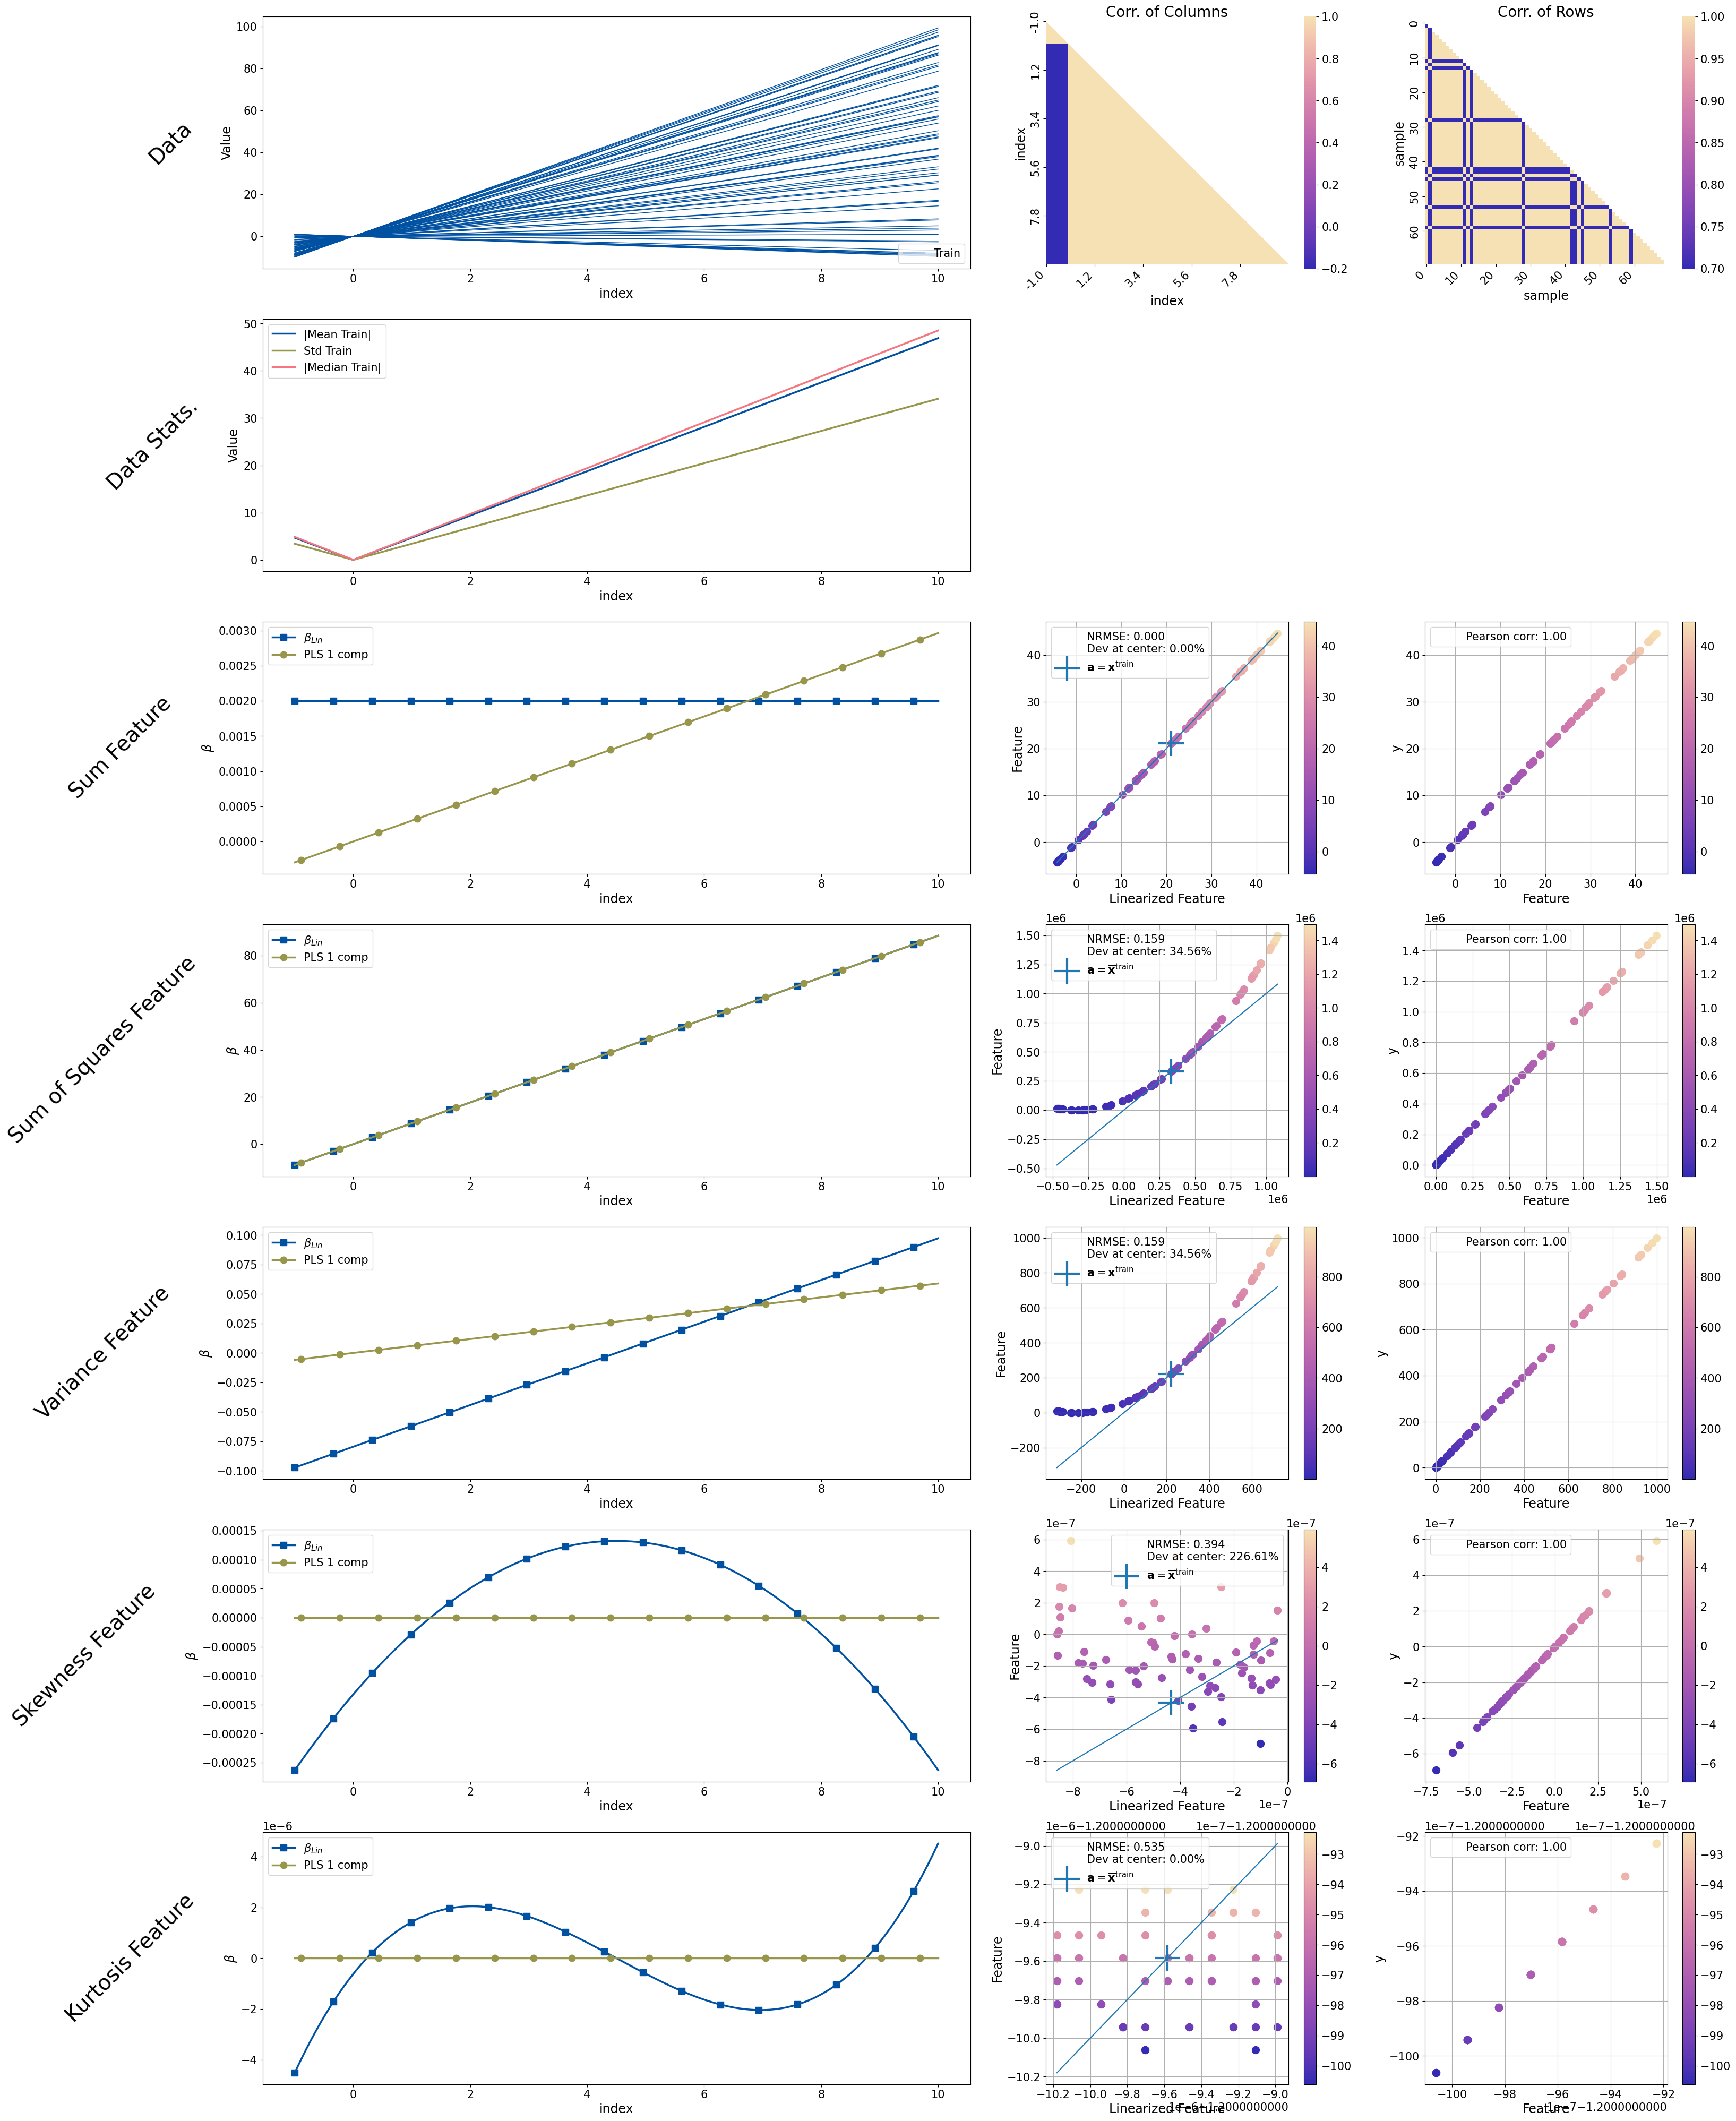

In [5]:
models = [
    PLSRegression(n_components=1, tol=1e-7, scale=False),
]
model_names = [
    'PLS 1 comp',
]
labels_syn = {'xdata_label': 'index', 'ydata_label': 'Value', 'row_label': 'sample'}
fig, axs = linearization_plots(x,  X_train_[:, :, 0], y_train_[:, :, 0], fun_targetj, fun_target_names, models, model_names, labels_syn, cmap)

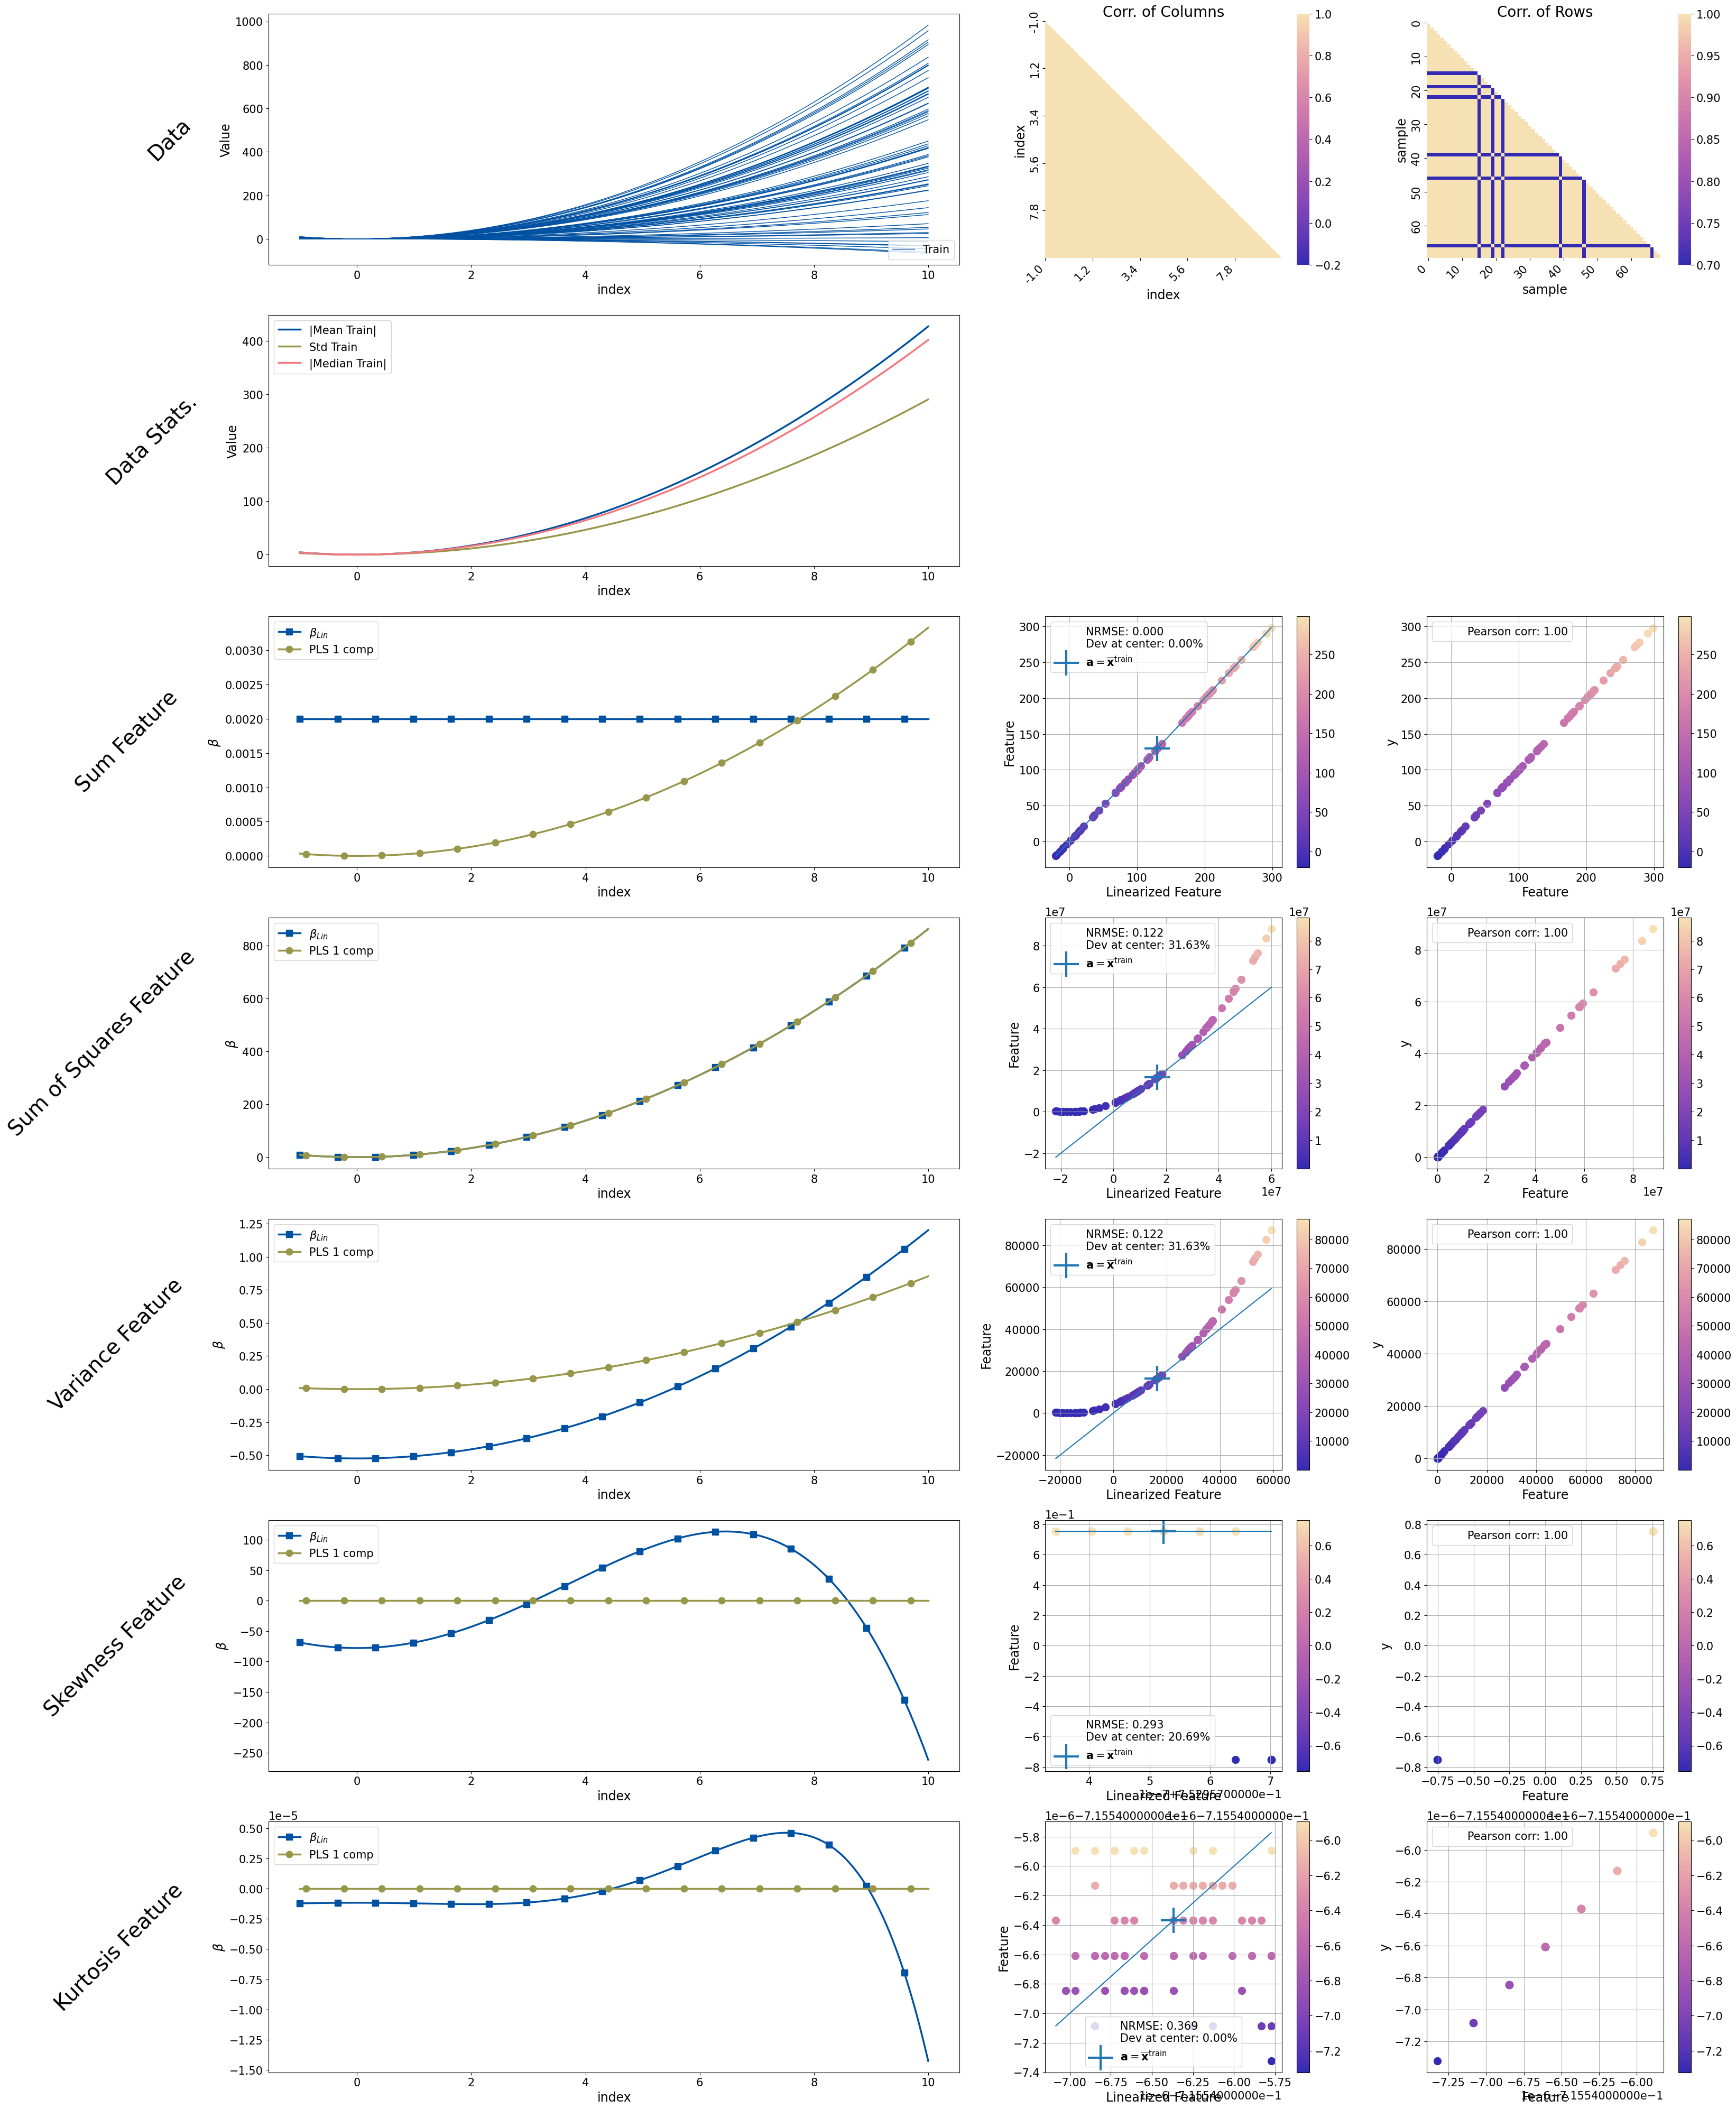

In [6]:
fig, axs = linearization_plots(x,  X_train_[:, :, 1], y_train_[:, :, 1], fun_targetj, fun_target_names, models, model_names, labels_syn, cmap)

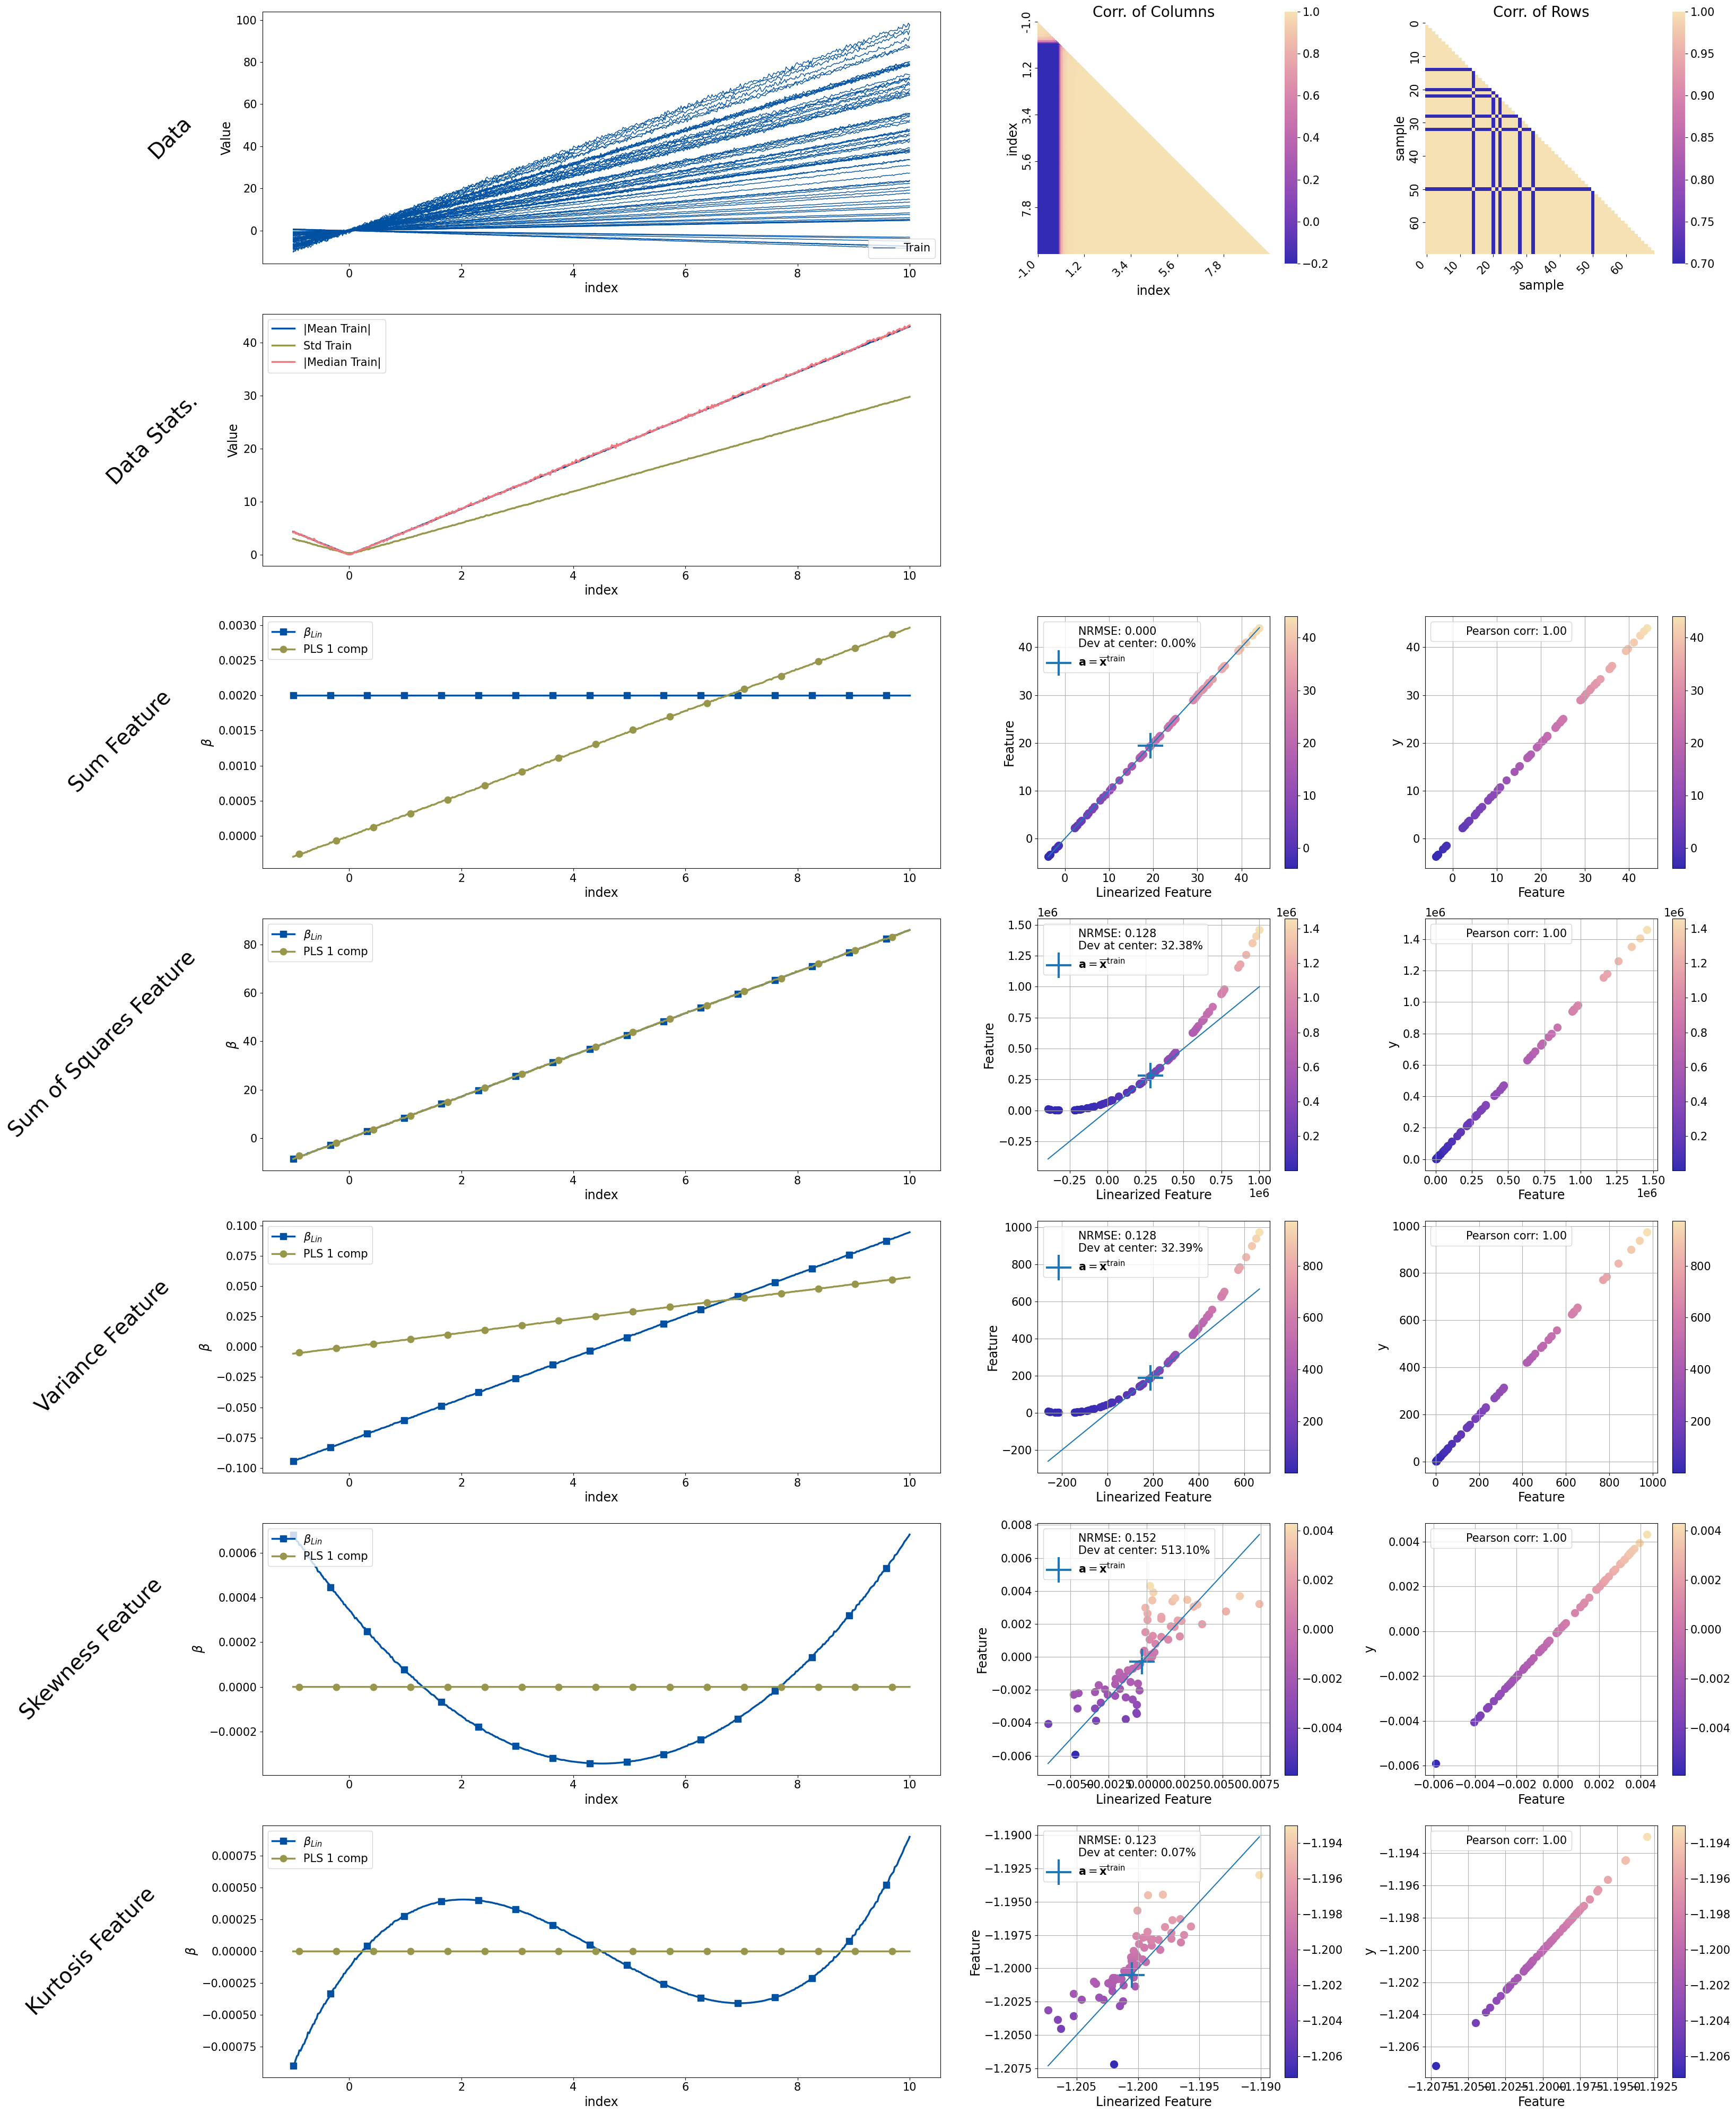

In [7]:
fig, axs = linearization_plots(x,  X_train_[:, :, 2], y_train_[:, :, 2], fun_targetj, fun_target_names, models, model_names, labels_syn, cmap)

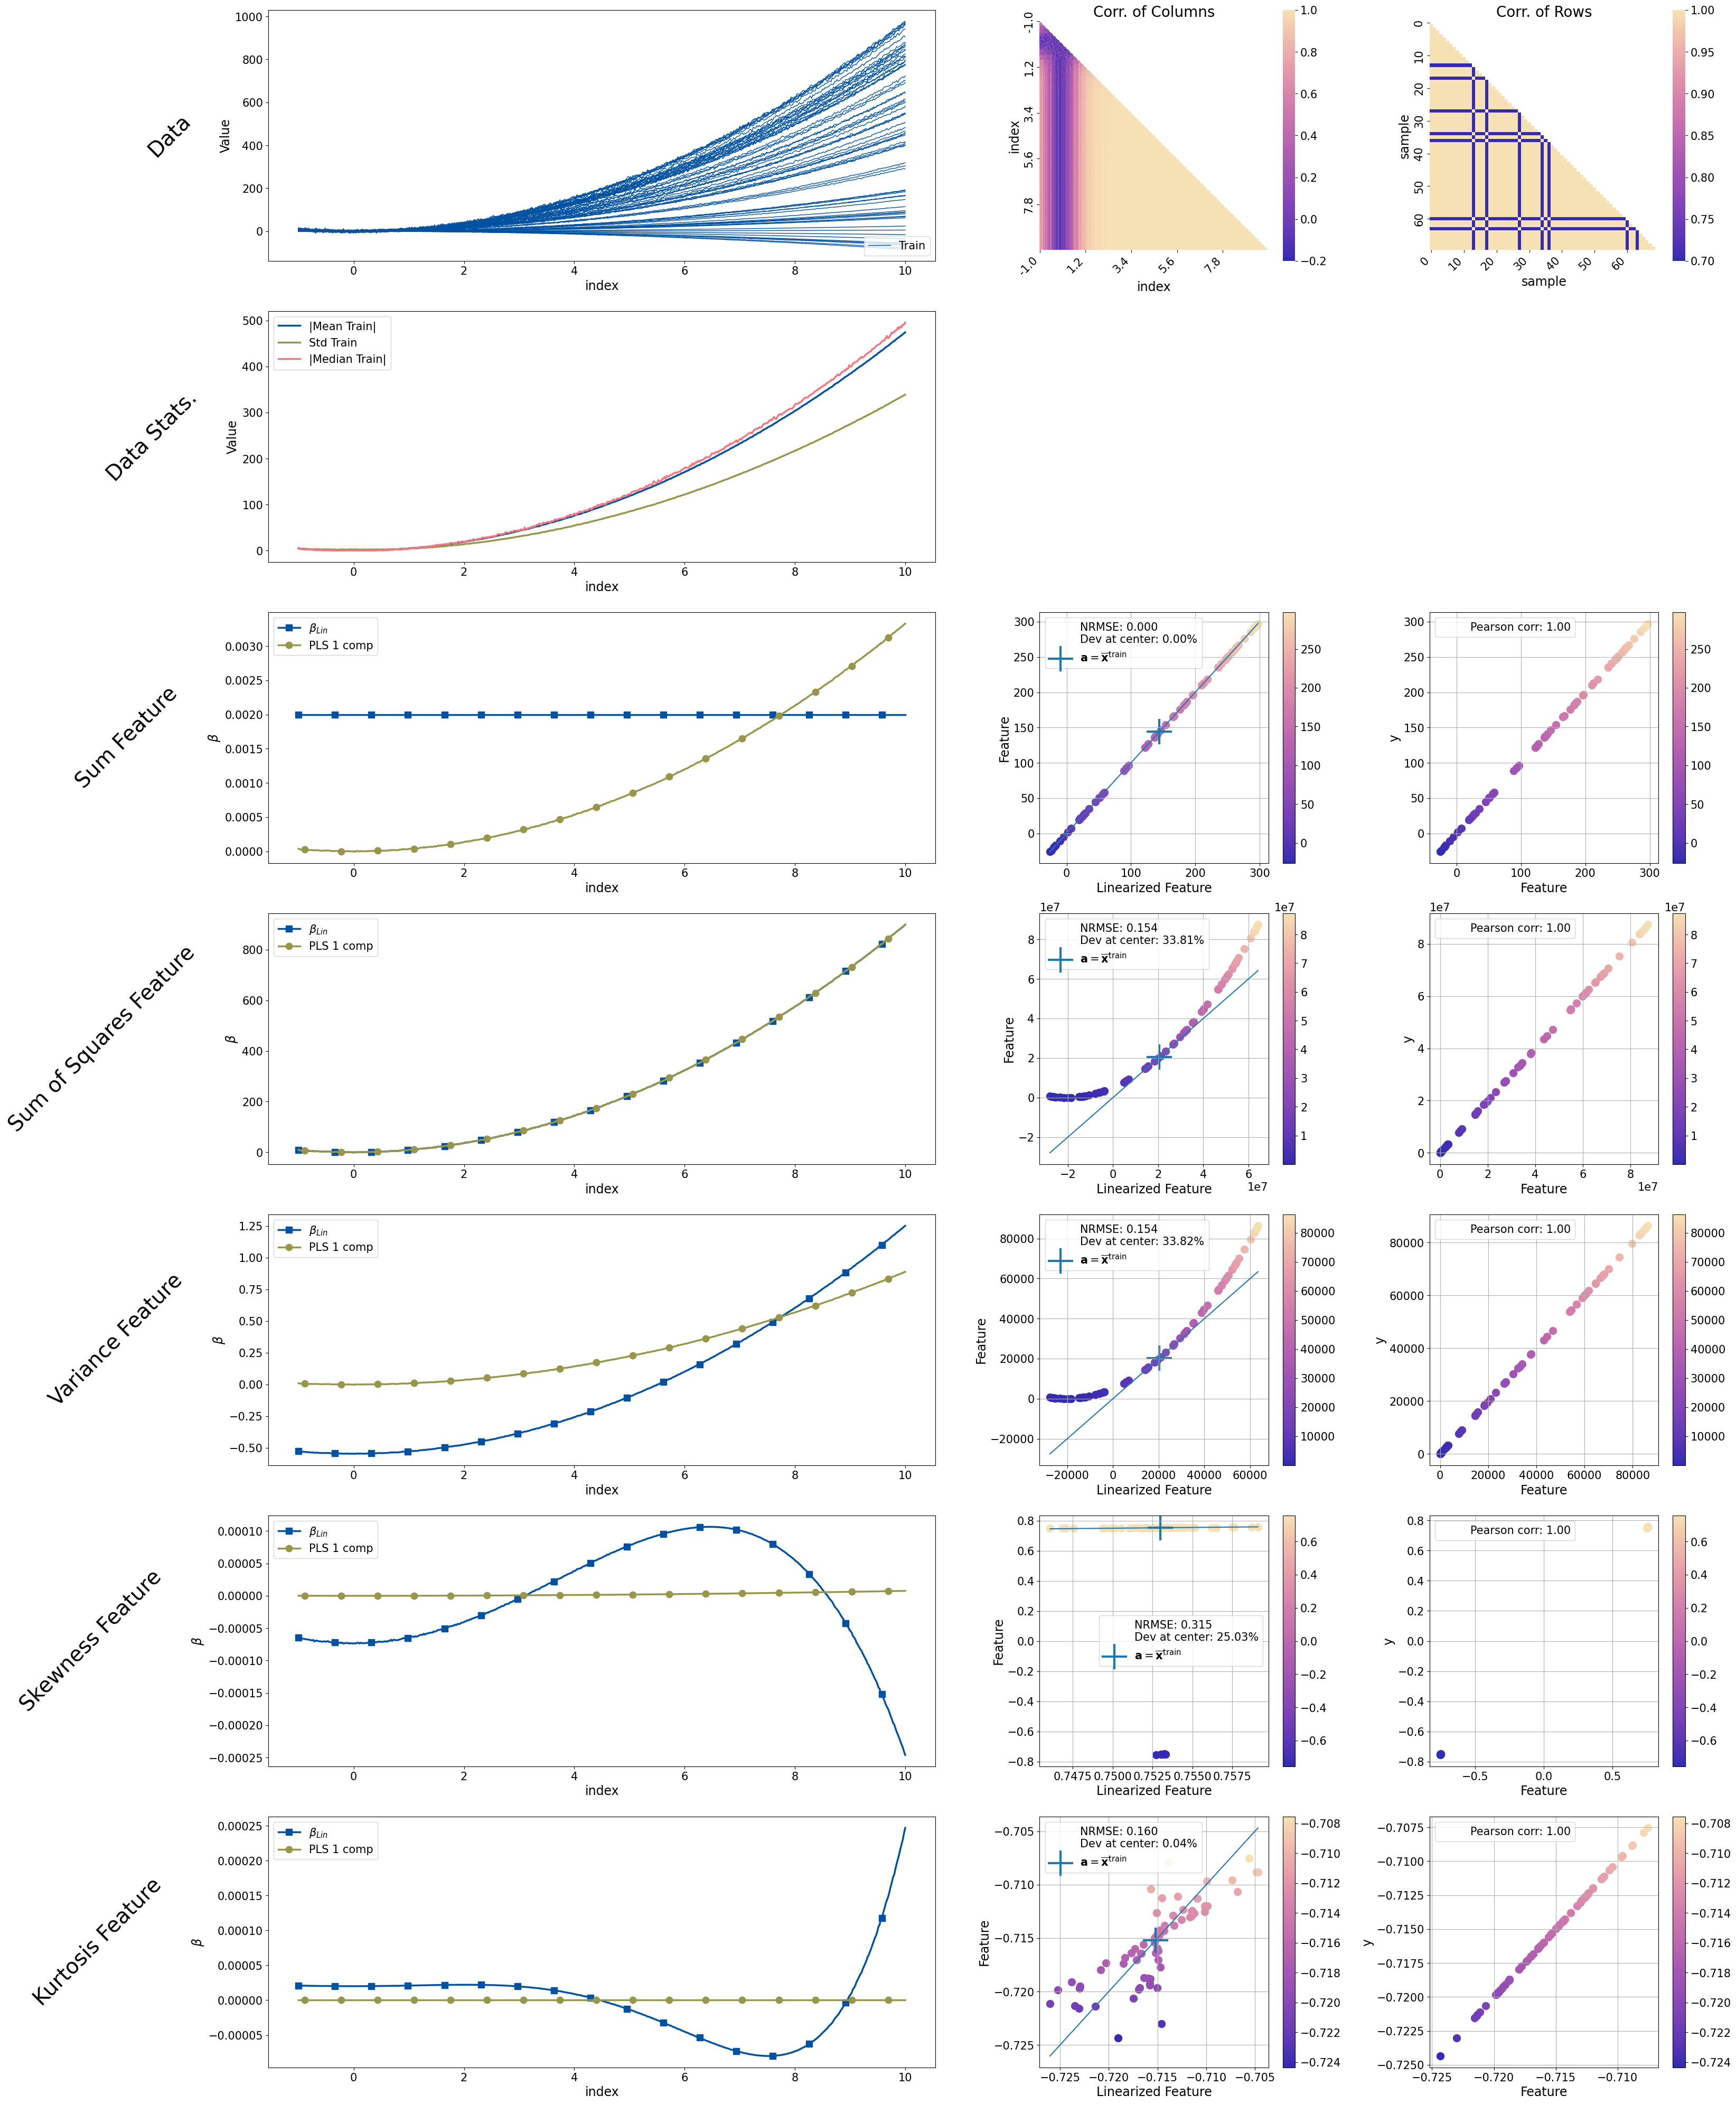

In [8]:
fig, axs = linearization_plots(x,  X_train_[:, :, 3], y_train_[:, :, 3], fun_targetj, fun_target_names, models, model_names, labels_syn, cmap)